In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# Veri setini yükleme
csv_path = "ct_image_labels_unprocessed.csv"
df = pd.read_csv(csv_path)
df["label"] = df["label"].astype(str)
df.head(1)

,file_path,label
0,unprocessed\inme_yok\pngs\10000.png,0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dataflow(df, img_height=128, img_width=128, batch_size=32, validation_split=0.2, augmentation=False):
    """
    Veri artırma (augmentation) opsiyonuna göre eğitim ve doğrulama veri akışlarını oluşturur.

    :param df: Veri çerçevesi (pandas DataFrame)
    :param img_height: Görselin hedef yüksekliği
    :param img_width: Görselin hedef genişliği
    :param batch_size: Mini batch boyutu
    :param validation_split: Eğitim ve doğrulama veri oranı
    :param augmentation: Veri artırma kullanılsın mı? (True / False)
    :return: Eğitim ve doğrulama için veri akış nesneleri
    """

    # Veri artırma seçenekleri
    if augmentation:
        datagen = ImageDataGenerator(
            rescale=1./255,            # Normalizasyon
            rotation_range=15,         # Resimleri 15 dereceye kadar döndür
            width_shift_range=0.1,     # Genişlikte %10 oranında kaydır
            height_shift_range=0.1,    # Yükseklikte %10 oranında kaydır
            shear_range=0.1,           # Hafif kaydırma dönüşümü uygula
            zoom_range=0.1,            # Hafif yakınlaştırma/uzaklaştırma yap
            horizontal_flip=True,      # Resimleri yatay olarak çevir
            validation_split=validation_split  # Eğitim ve doğrulama bölme oranı
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,  # Sadece normalizasyon
            validation_split=validation_split
        )

    # Eğitim veri seti (her zaman shuffle=True olmalı)
    train_generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col="file_path",
        y_col="label",
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        shuffle=True
    )

    # Doğrulama veri seti (shuffle=False olmalı)
    val_generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col="file_path",
        y_col="label",
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",
        shuffle=False
    )

    return train_generator, val_generator


In [5]:
train_generator, val_generator = create_dataflow(df, augmentation=False)

Found 5320 validated image filenames belonging to 2 classes.
Found 1330 validated image filenames belonging to 2 classes.


In [6]:
from tensorflow.keras import layers, models
img_height=128 
img_width=128

In [ ]:


model_simple = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the layers

model_vgg16 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


In [9]:
from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_resnet.trainable = False

model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


In [9]:
from tensorflow.keras.applications import InceptionV3

base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_inception.trainable = False

model_inception = models.Sequential([
    base_model_inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


In [5]:
def save_history_as_dict(model, modelname, path="histories"):
    # Klasör varsa oluştur
    os.makedirs(path, exist_ok=True)
    
    # Modelin history nesnesini al
    history_dict = model.history.history
    
    # Sözlüğe çevirme
    formatted_history = {
        epoch + 1: {
            "accuracy": history_dict["accuracy"][epoch], 
            "loss": history_dict["loss"][epoch],
            "val_accuracy": history_dict["val_accuracy"][epoch], 
            "val_loss": history_dict["val_loss"][epoch]
        }
        for epoch in range(len(history_dict["accuracy"]))
    }
    
    # `.pkl` dosyası olarak kaydet
    with open(f"{path}/{modelname}_history.pkl", "wb") as file:
        pickle.dump(formatted_history, file)
    
    print("History başarıyla kaydedildi!")
    

In [6]:
def read_history_as_dict(modelname, path = "histories"):
    # `.pkl` dosyasını yükle
    with open(f"{path}/{modelname}_history.pkl", "rb") as file:
        loaded_history = pickle.load(file)
    
    # Sonuçları kontrol et
    print(loaded_history)
    return loaded_history

In [7]:
def plot_training_history(history_dict):
    """
    Eğitim geçmişi sözlüğünü kullanarak accuracy ve loss grafikleri çizen fonksiyon.

    :param history_dict: Epoch numaralarını içeren sözlük 
                         {1: {"accuracy": .., "loss": .., "val_accuracy": .., "val_loss": ..}, ...}
    """

    # Epoch numaralarını al
    epochs = list(history_dict.keys())

    # Metrikleri al
    acc = [history_dict[e]["accuracy"] for e in epochs]
    val_acc = [history_dict[e]["val_accuracy"] for e in epochs]
    loss = [history_dict[e]["loss"] for e in epochs]
    val_loss = [history_dict[e]["val_loss"] for e in epochs]

    # Accuracy grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy", marker="o")
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    
    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss", marker="o")
    plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.show()


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback'ini tanımlıyoruz
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
# Basit CNN Modeli
print("Simple CNN")
model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_simple = model_simple.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])
print("\n")

Simple CNN
Epoch 1/10
167/167 [==============================] - 138s 821ms/step - loss: 0.4965 - accuracy: 0.7526 - val_loss: 0.2564 - val_accuracy: 0.9143
Epoch 2/10
167/167 [==============================] - 91s 548ms/step - loss: 0.2420 - accuracy: 0.8968 - val_loss: 0.1778 - val_accuracy: 0.9346
Epoch 3/10
167/167 [==============================] - 88s 528ms/step - loss: 0.1009 - accuracy: 0.9637 - val_loss: 0.1974 - val_accuracy: 0.9211
Epoch 4/10
167/167 [==============================] - 84s 504ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.0720 - val_accuracy: 0.9714
Epoch 5/10
167/167 [==============================] - 82s 491ms/step - loss: 0.0298 - accuracy: 0.9904 - val_loss: 0.0710 - val_accuracy: 0.9789
Epoch 6/10
167/167 [==============================] - 87s 522ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.1331 - val_accuracy: 0.9541
Epoch 7/10
167/167 [==============================] - 86s 516ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1

In [19]:
# VGG16 Modeli Kaydetme
model_simple.save('models/unprocessed/model_simple.h5')

In [22]:
save_history_as_dict(model_simple, "model_simple", "histories/unprocessed")

History başarıyla kaydedildi!


In [7]:
history_dict_cnn = read_history_as_dict("model_simple", "histories/unprocessed")

{1: {'accuracy': 0.7526316046714783, 'loss': 0.4964691400527954, 'val_accuracy': 0.9142857193946838, 'val_loss': 0.2564152479171753}, 2: {'accuracy': 0.8968045115470886, 'loss': 0.24201485514640808, 'val_accuracy': 0.9345864653587341, 'val_loss': 0.17775475978851318}, 3: {'accuracy': 0.9637218117713928, 'loss': 0.10092834383249283, 'val_accuracy': 0.9210526347160339, 'val_loss': 0.19735930860042572}, 4: {'accuracy': 0.9879699349403381, 'loss': 0.03748329356312752, 'val_accuracy': 0.9714285731315613, 'val_loss': 0.07196070998907089}, 5: {'accuracy': 0.9904135465621948, 'loss': 0.029789013788104057, 'val_accuracy': 0.9789473414421082, 'val_loss': 0.07099030911922455}, 6: {'accuracy': 0.9932330846786499, 'loss': 0.023587195202708244, 'val_accuracy': 0.9541353583335876, 'val_loss': 0.13306596875190735}, 7: {'accuracy': 1.0, 'loss': 0.0022575624752789736, 'val_accuracy': 0.9548872113227844, 'val_loss': 0.12504710257053375}, 8: {'accuracy': 0.9979323148727417, 'loss': 0.008501702919602394, '

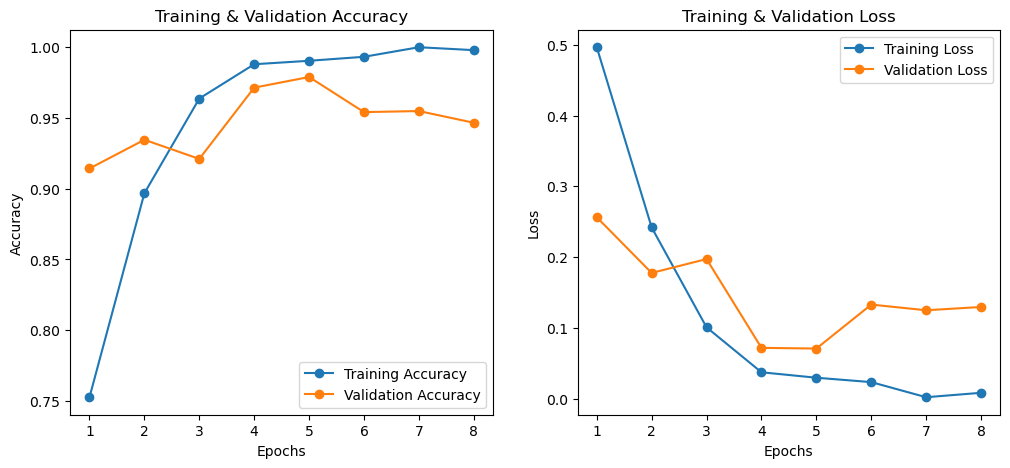

In [10]:
plot_training_history(history_dict_cnn)

In [11]:
# VGG16 Modeli
print("VGG16")
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_vgg16 = model_vgg16.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])
print("\n")

VGG16
Epoch 1/10
167/167 [==============================] - 270s 2s/step - loss: 0.6429 - accuracy: 0.6248 - val_loss: 0.4693 - val_accuracy: 0.9203
Epoch 2/10
167/167 [==============================] - 285s 2s/step - loss: 0.5844 - accuracy: 0.7086 - val_loss: 0.4795 - val_accuracy: 0.8496
Epoch 3/10
167/167 [==============================] - 245s 1s/step - loss: 0.5511 - accuracy: 0.7372 - val_loss: 0.3550 - val_accuracy: 0.9256
Epoch 4/10
167/167 [==============================] - 248s 1s/step - loss: 0.5282 - accuracy: 0.7570 - val_loss: 0.3929 - val_accuracy: 0.8872
Epoch 5/10
167/167 [==============================] - 244s 1s/step - loss: 0.5090 - accuracy: 0.7701 - val_loss: 0.4037 - val_accuracy: 0.8707
Epoch 6/10
167/167 [==============================] - 241s 1s/step - loss: 0.4935 - accuracy: 0.7774 - val_loss: 0.4154 - val_accuracy: 0.8564




In [12]:
# VGG16 Modeli Kaydetme
model_vgg16.save('models/unprocessed/model_vgg16.h5')

In [17]:
save_history_as_dict(model_vgg16, "model_vgg16", "histories/unprocessed")

History başarıyla kaydedildi!


In [7]:
history_dict_vgg16 = read_history_as_dict("model_vgg16", "histories/unprocessed")

{1: {'accuracy': 0.6248120069503784, 'loss': 0.6429382562637329, 'val_accuracy': 0.9203007221221924, 'val_loss': 0.46927109360694885}, 2: {'accuracy': 0.7086465954780579, 'loss': 0.5844109654426575, 'val_accuracy': 0.8496240377426147, 'val_loss': 0.47954657673835754}, 3: {'accuracy': 0.7372180223464966, 'loss': 0.5510799288749695, 'val_accuracy': 0.9255639314651489, 'val_loss': 0.3549903929233551}, 4: {'accuracy': 0.7569549083709717, 'loss': 0.5281628370285034, 'val_accuracy': 0.8872180581092834, 'val_loss': 0.3929443955421448}, 5: {'accuracy': 0.7701127529144287, 'loss': 0.5090456008911133, 'val_accuracy': 0.8706766963005066, 'val_loss': 0.4036894738674164}, 6: {'accuracy': 0.7774435877799988, 'loss': 0.4934936463832855, 'val_accuracy': 0.8563909530639648, 'val_loss': 0.4154435098171234}}


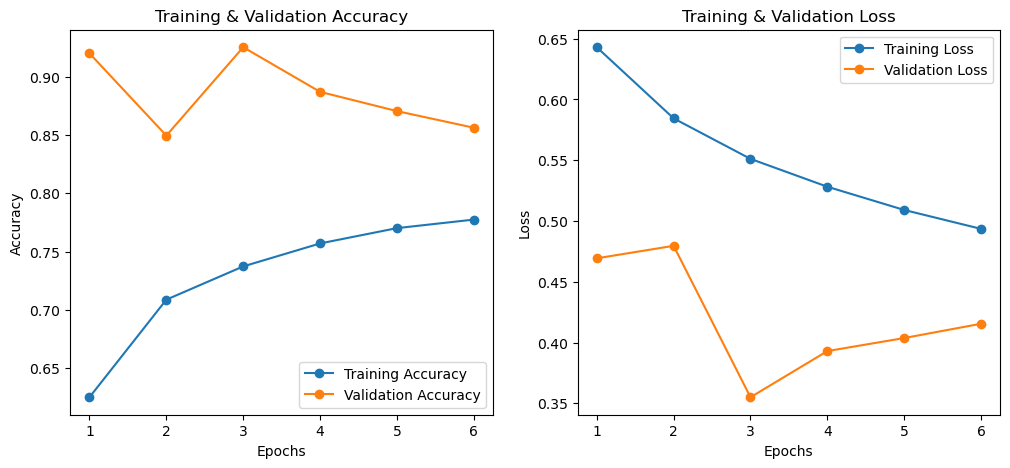

In [8]:
plot_training_history(history_dict_vgg16)

In [14]:
# ResNet50 Modeli
print("ResNet50")
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet = model_resnet.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])
print("\n")

ResNet50
Epoch 1/10
167/167 [==============================] - 114s 664ms/step - loss: 0.6531 - accuracy: 0.6066 - val_loss: 0.5937 - val_accuracy: 0.7451
Epoch 2/10
167/167 [==============================] - 118s 707ms/step - loss: 0.6118 - accuracy: 0.6628 - val_loss: 0.5149 - val_accuracy: 0.8286
Epoch 3/10
167/167 [==============================] - 123s 736ms/step - loss: 0.5885 - accuracy: 0.6979 - val_loss: 0.4693 - val_accuracy: 0.8489
Epoch 4/10
167/167 [==============================] - 129s 773ms/step - loss: 0.5742 - accuracy: 0.7126 - val_loss: 0.4862 - val_accuracy: 0.8030
Epoch 5/10
167/167 [==============================] - 127s 758ms/step - loss: 0.5624 - accuracy: 0.7212 - val_loss: 0.4489 - val_accuracy: 0.8353
Epoch 6/10
167/167 [==============================] - 125s 750ms/step - loss: 0.5534 - accuracy: 0.7241 - val_loss: 0.3932 - val_accuracy: 0.8782
Epoch 7/10
167/167 [==============================] - 115s 687ms/step - loss: 0.5474 - accuracy: 0.7261 - val_loss:

In [16]:
# ResNet50 Modeli Kaydetme
model_resnet.save('models/unprocessed/model_resnet.h5')

In [91]:
save_history_as_dict(model_resnet, "model_resnet")

History başarıyla kaydedildi!


{1: {'accuracy': 0.5821428298950195,
  'loss': 0.6806248426437378,
  'val_accuracy': 1.0,
  'val_loss': 0.5588709115982056},
 2: {'accuracy': 0.5838345885276794,
  'loss': 0.6734024286270142,
  'val_accuracy': 0.9909774661064148,
  'val_loss': 0.5997154116630554},
 3: {'accuracy': 0.5872180461883545,
  'loss': 0.6684167981147766,
  'val_accuracy': 0.9939849376678467,
  'val_loss': 0.5462575554847717},
 4: {'accuracy': 0.598308265209198,
  'loss': 0.6649572849273682,
  'val_accuracy': 0.9947368502616882,
  'val_loss': 0.5168308615684509},
 5: {'accuracy': 0.6052631735801697,
  'loss': 0.6613319516181946,
  'val_accuracy': 0.9774436354637146,
  'val_loss': 0.538167417049408},
 6: {'accuracy': 0.6167293190956116,
  'loss': 0.6574729681015015,
  'val_accuracy': 0.9789473414421082,
  'val_loss': 0.5182328820228577},
 7: {'accuracy': 0.6233082413673401,
  'loss': 0.6538082957267761,
  'val_accuracy': 0.9729323387145996,
  'val_loss': 0.517287015914917}}

In [12]:
history_dict_resnet = read_history_as_dict("model_resnet", "histories/unprocessed/")

{1: {'accuracy': 0.6065789461135864, 'loss': 0.6530818939208984, 'val_accuracy': 0.7451127767562866, 'val_loss': 0.5937202572822571}, 2: {'accuracy': 0.6627819538116455, 'loss': 0.6117619276046753, 'val_accuracy': 0.8285714387893677, 'val_loss': 0.5149281620979309}, 3: {'accuracy': 0.6979323029518127, 'loss': 0.5884656310081482, 'val_accuracy': 0.848872184753418, 'val_loss': 0.4692527949810028}, 4: {'accuracy': 0.7125939726829529, 'loss': 0.5742274522781372, 'val_accuracy': 0.8030075430870056, 'val_loss': 0.48617613315582275}, 5: {'accuracy': 0.7212405800819397, 'loss': 0.5623502731323242, 'val_accuracy': 0.8353383541107178, 'val_loss': 0.44887053966522217}, 6: {'accuracy': 0.7240601778030396, 'loss': 0.5533803105354309, 'val_accuracy': 0.8781954646110535, 'val_loss': 0.3932003974914551}, 7: {'accuracy': 0.7261278033256531, 'loss': 0.5474383234977722, 'val_accuracy': 0.8646616339683533, 'val_loss': 0.40376922488212585}, 8: {'accuracy': 0.731766939163208, 'loss': 0.54116290807724, 'val_

In [ ]:
plot_training_history(history_dict_resnet)

In [12]:
# InceptionV3 Modeli
print("InceptionV3")
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_inception = model_inception.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])

InceptionV3
Epoch 1/10
167/167 [==============================] - 153s 894ms/step - loss: 0.5643 - accuracy: 0.7297 - val_loss: 0.3652 - val_accuracy: 0.8316
Epoch 2/10
167/167 [==============================] - 87s 523ms/step - loss: 0.4261 - accuracy: 0.8032 - val_loss: 0.1689 - val_accuracy: 0.9391
Epoch 3/10
167/167 [==============================] - 86s 517ms/step - loss: 0.3994 - accuracy: 0.8222 - val_loss: 0.2767 - val_accuracy: 0.8887
Epoch 4/10
167/167 [==============================] - 96s 577ms/step - loss: 0.3750 - accuracy: 0.8295 - val_loss: 0.1836 - val_accuracy: 0.9368
Epoch 5/10
167/167 [==============================] - 91s 544ms/step - loss: 0.3675 - accuracy: 0.8368 - val_loss: 0.7439 - val_accuracy: 0.6579


In [13]:
# InceptionV3 Modeli Kaydetme
model_inception.save('models/unprocessed/model_inception.h5')

In [14]:
save_history_as_dict(model_inception, "model_inception", "histories/unprocessed")

History başarıyla kaydedildi!


In [8]:
history_dict_inception = read_history_as_dict("model_inception", "histories/unprocessed/")

{1: {'accuracy': 0.7296992540359497, 'loss': 0.5643005967140198, 'val_accuracy': 0.8315789699554443, 'val_loss': 0.36519914865493774}, 2: {'accuracy': 0.8031954765319824, 'loss': 0.4261019229888916, 'val_accuracy': 0.9390977621078491, 'val_loss': 0.16889551281929016}, 3: {'accuracy': 0.822180449962616, 'loss': 0.39942824840545654, 'val_accuracy': 0.8887218236923218, 'val_loss': 0.2767188549041748}, 4: {'accuracy': 0.829511284828186, 'loss': 0.37503722310066223, 'val_accuracy': 0.9368420839309692, 'val_loss': 0.18355563282966614}, 5: {'accuracy': 0.8368421196937561, 'loss': 0.36748865246772766, 'val_accuracy': 0.6578947305679321, 'val_loss': 0.7439345717430115}}


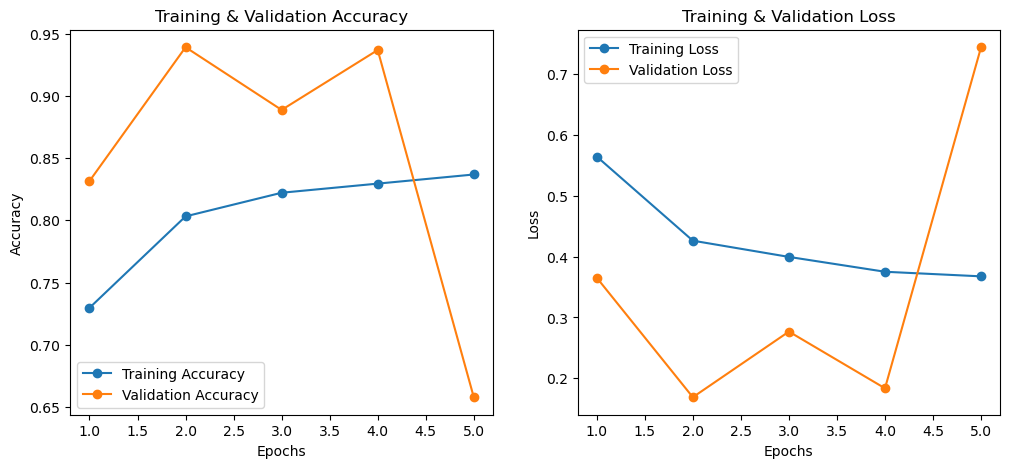

In [9]:
plot_training_history(history_dict_inception)